In [1]:
import requests
import json
import time
import itertools
import wget
import os
import pickle
import numpy as np

import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.metrics import precision_recall_curve
import scipy

sns.set_style('white')
import tensorflow as tf
import pandas as pd
import keras
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import keras.initializers as init
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import load_model

Using TensorFlow backend.


In [2]:
x_train_dict = pickle.load(open('training_num.pik' , 'rb'))

In [3]:
train_split = 8000

In [4]:
x_train_raw = x_train_dict['images']

x_train = np.array(x_train_raw)[:train_split,: ,: , :]
x_test  = np.array(x_train_raw)[train_split:,: ,: , :]

print x_train.shape

(8000, 128, 85, 3)


In [5]:
img_rows = x_train.shape[1]

img_cols = x_train.shape[2]

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
    
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


In [6]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

x_train /= 255.0
x_test  /= 255.0

print 'x_train shape:', x_train.shape
print  x_train.shape[0], 'train samples'

print 'x_test shape:', x_test.shape
print  x_test.shape[0], 'test samples'

x_train shape: (8000, 128, 85, 3)
8000 train samples
x_test shape: (1988, 128, 85, 3)
1988 test samples


In [7]:
y_raw = pd.read_csv('Genres_labels_All_cleaned.csv')

y_train = y_raw.iloc[:, 1:-1].values[:train_split, :]
y_test  = y_raw.iloc[:, 1:-1].values[train_split:, :]

num_classes = y_train.shape[1]



In [8]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range = 0.5,
    fill_mode = 'wrap')

datagen.fit(x_train)

datagen.fit(x_test)

In [10]:
# create an empty network model
model3 = Sequential()

# --- input layer ---
model3.add(Conv2D(32, kernel_size=(7, 7), activation='relu', input_shape=input_shape , 
                 kernel_initializer = init.he_normal(109)))

# --- max pool ---
model3.add(MaxPooling2D(pool_size=(2, 2)))


# ---- Conv Layer ---
model3.add(Conv2D(32, kernel_size=(5, 5), activation='relu', 
                kernel_initializer = init.he_normal(109)))

# --- max pool ---
model3.add(MaxPooling2D(pool_size=(2, 2)))

# --- Conv layer ---
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu',
               kernel_initializer = init.he_normal(109)))

# --- max pool ---
model3.add(MaxPooling2D(pool_size=(2, 2)))

# --- Conv layer ---
model3.add(Conv2D(64, kernel_size=(3, 3), activation='relu' ,
               kernel_initializer = init.he_normal(109)))

# --- max pool ---
model3.add(MaxPooling2D(pool_size=(2, 2)))


# flatten for fully connected classification layer
model3.add(Flatten())

# --- fully connected layer ---
model3.add(Dense(128, activation='relu',
              kernel_initializer = init.he_normal(109)))

# --- fully connected layer ---
model3.add(Dense(64, activation='relu' ,
               kernel_initializer = init.he_normal(109)))

# --- classification ---
model3.add(Dense(num_classes, activation='sigmoid'))

# prints out a summary of the model architecture
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 122, 79, 32)       4736      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 39, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 57, 35, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 28, 17, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 26, 15, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 13, 7, 64)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 11, 5, 64)         36928     
__________

In [11]:
ada = Adam(lr=1e-6)
model3.compile(loss='binary_crossentropy',
              optimizer=ada,
              metrics=['accuracy'])

In [12]:
# Batch Size
batch_size = 64

# epochs
epochs = 30

In [13]:
history = model3.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                              steps_per_epoch = len(x_train) / batch_size, 
                              epochs=epochs,
                              validation_data = (x_test, y_test),
                              validation_steps = len(x_test) / batch_size)

Epoch 1/30
125/125 [==============================] - 18s - loss: 0.8804 - acc: 0.5435 - val_loss: 0.7248 - val_acc: 0.5571

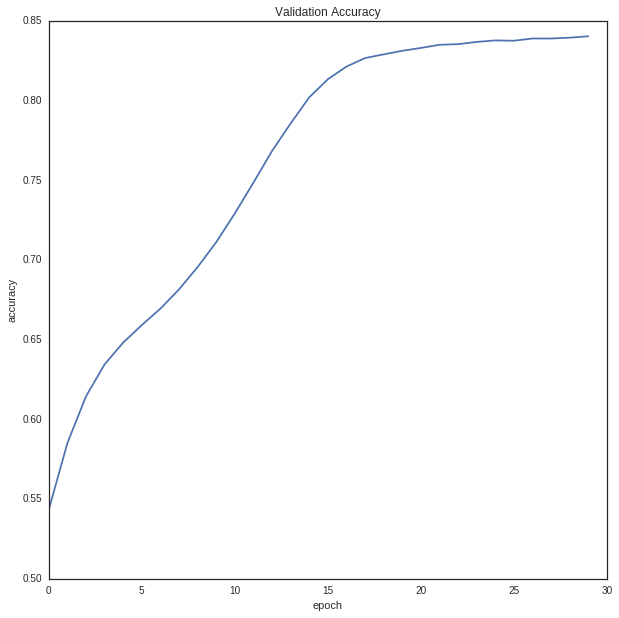

In [14]:
fig = plt.figure (figsize = (10,10))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(history.history['acc'])
ax1.set_xlabel("epoch")
ax1.set_title('Validation Accuracy')
ax1.set_ylabel("accuracy")
plt.show()

In [16]:
import h5py as h5py

In [17]:
model2.save('cnn_4.h5')

In [18]:
Acc_arch1_var4 = pd.DataFrame(history.history['acc'] , columns = ['Accuracy'])

In [19]:
Acc_arch1_var4.to_csv('Accuracy_ver3.csv')